In [14]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import folium

In [15]:
regions = pd.read_csv('data/regions.csv', sep=';')
regions.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


In [16]:
data_storage = 'D:/Data/taxi/aggs/' # путь, где хранятся данные о поездках
aggs_data = pd.read_csv(data_storage+'taxi-2016-05.csv')

NY_border={'W': -74.25559, 'E': -73.70001, 'S': 40.49612, 'N': 40.91553}
cx, cy =  (NY_border['S'] + NY_border['N']) / 2, (NY_border['W'] + NY_border['E']) / 2
ESB = (-73.985664, 40.748441) 

Число районов, из которых в мае не было совершено ни одной поездки:

In [17]:
aggs_data.sum().eq(0).sum()

1283

Построим статическую карту, на которой визуализированы районы, раскрашенные по частоте поездок. 

In [18]:
lon = np.unique(regions[['west', 'east']].values)
lat = np.unique(regions[['south', 'north']].values)
lon, lat = np.meshgrid(lon, lat)

counts = aggs_data.sum().values.reshape(50, 50)

c:\python 3.6.8 x64\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
c:\python 3.6.8 x64\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


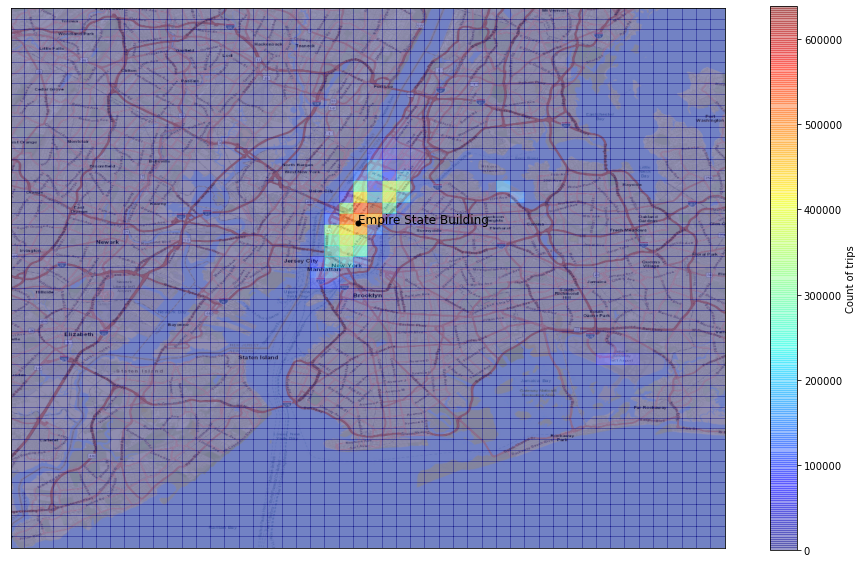

In [19]:
fig = plt.figure(num=None, figsize=(16, 10) ) 
m = Basemap(llcrnrlon=NY_border['W'], llcrnrlat=NY_border['S'], urcrnrlon=NY_border['E'], urcrnrlat=NY_border['N'],
            resolution='h', projection='lcc', epsg=4326)

m.arcgisimage(service='World_Street_Map', xpixels=1200, epsg=4269)

m.pcolormesh(lon, lat, counts.T, latlon=True, cmap=plt.get_cmap('jet'), edgecolors='face', alpha=0.4, linewidth=0)

# m.drawparallels(np.arange(NY_border['S'], NY_border['N'],0.1),labels=[True,False,False,False])
# m.drawmeridians(np.arange(NY_border['W'], NY_border['E'], 0.1),labels=[False,False,False,True])

plt.plot(ESB[0],ESB[1], 'ok', markersize=5)
plt.text(ESB[0], ESB[1], 'Empire State Building', fontsize=12);


plt.colorbar(label='Count of trips')
plt.show()

Проверим, не было ли таких регионов, из которых были совершены поездки, но на деле они были невозможны (например, из водоемов). Для этого проведем трансофрмацию, которая чувствительна к небольшим изменениям, для того, чтобы посмотреть на районы с небольшим числом поездок.  

In [20]:
def transform(x, t=0.1):
    return pow(x,t)/pow(2,t-1)

c:\python 3.6.8 x64\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
c:\python 3.6.8 x64\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


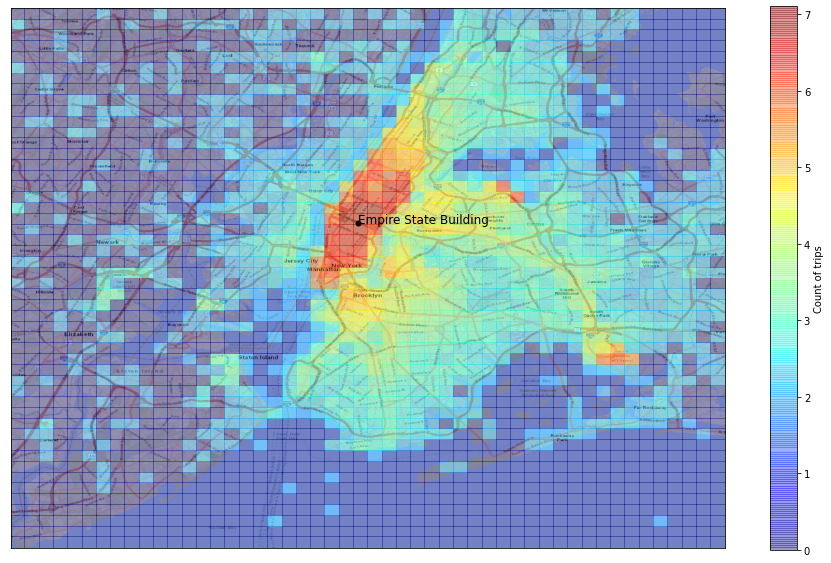

In [21]:
fig = plt.figure(num=None, figsize=(16, 10) ) 
m = Basemap(llcrnrlon=NY_border['W'], llcrnrlat=NY_border['S'], urcrnrlon=NY_border['E'], urcrnrlat=NY_border['N'],
            resolution='h', projection='lcc', epsg=4326)

m.arcgisimage(service='World_Street_Map', xpixels=1200, epsg=4269)

m.pcolormesh(lon, lat, transform(counts).T, latlon=True, cmap=plt.get_cmap('jet'), edgecolors='face', alpha=0.4, linewidth=0)


plt.plot(ESB[0],ESB[1], 'ok', markersize=5)
plt.text(ESB[0], ESB[1], 'Empire State Building', fontsize=12);


plt.colorbar(label='Count of trips')
plt.show()

Видно, что есть регионы, которые находятся в водоемах, но из них были совершены поездки (например, регионы в море). Соответствено, делаем вывод, что в данных присутствует некоторый шум. 

Теперь рассмотрим данные по среднему числу поездок за месяц и отфильтруем их. Будем рассматривать данные, у которых средние >= 5. 

In [22]:
regions['means'] = aggs_data.mean().values
geo = regions[regions['means']>=5]

In [23]:
geo.head(3)

,region,west,east,south,north,means
1074,1075,-74.022246,-74.011135,40.697437,40.705825,66.799731
1075,1076,-74.022246,-74.011135,40.705825,40.714213,138.266129
1076,1077,-74.022246,-74.011135,40.714213,40.722601,86.802419


Число таких регинов:

In [25]:
geo.shape[0]

102

Теперь построим интерактивную карту и на ней визуализируем эти районы. Для функции folium.Choropleth геоданные нужны в формате GeoJson. Перезапишем их из нашего датафрейма geo в виде соответствующего GeoJson словаря.

In [26]:
geo_data = []

for i, k in geo.iterrows():
    geodata= {"type": "Polygon", "coordinates": [[[k['west'], k['north']], [k['east'], k['north']], [k['east'], k['south']], [k['west'],k['south']], [k['west'],k['north']]]]}
    feat = {"type": "Feature", "properties": {"id": i+1}, "geometry": geodata}
    geo_data.append(feat)

geo_data_fin = {"type":"FeatureCollection", "features":geo_data}

Теперь отрисуем карту:

In [27]:
bins = list(geo["means"].quantile([0, 0.7, 0.85, 0.95, 1]))

m = folium.Map(location=[cx, cy])

folium.Choropleth(
    geo_data=geo_data_fin,
    name="choropleth",
    data=geo,
    columns=["region", "means"],
    key_on="feature.properties.id",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.4,
    legend_name="Means number of trips",
    bins=bins,
).add_to(m)

folium.Marker([40.689247, -74.044502], popup="<i>Statue of Liberty</i>").add_to(m)

m

Судя по карте, все поездки из данных регионов возможны. Сохраним карту в формате html:

In [170]:
m.save('data/map_taxi.html')